
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **El Pulso Político de Twitter Análisis de las Elecciones de Madrid 2023**
### <p style="text-align:center"> **4. Modelos. Prediccion de partido político**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. EDA y Selección/Preparación de variables.
 2. Análisis gráfico y  Word Cloud.
 3. Modelos. Predicción de sentimiento.
 4. <font color='darkgreen'> **Modelos. Predicción de Partido político.**</font>
 5. Fine tunning GPT3- Davinci. Predicción de sentimiento.
 6. Fine tunning GPT3- Davinci. Predicción de Partido político.

En este cuaderno, aplicaremos modelos de aprendizaje automático para realizar predicciones del partido político asociado a los tweets. Los modelos que utilizaremos son:

- SVM
- Naive Bayes
- XGBoost Classifier
- RandomForest
- Logistic Regression

Luego de evaluar el rendimiento de estos modelos, realizaremos una optimización de hiperparámetros (hyperparameter tuning) en los dos mejores modelos seleccionados. El objetivo de esta optimización es mejorar los resultados de las predicciones del partido político asociado a los tweets.

En resumen, utilizaremos varios modelos de clasificación para predecir el partido político asociado a los tweets y posteriormente mejoraremos los dos mejores modelos mediante la optimización de hiperparámetros.

  **INDICE:**
 
 - [Importación de Librerias](#0)
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Vectorización y división entre train y test](#3)
 - [Modelización. Prueba de modelos (SVM, Naive Bayes, XGBoost Classifier, RandomForest, Logistic Regression)](#3.9)

  **Modelos:**
 - [SVM](#4)
 - [Naive Bayes](#5) 
 - [XGBoost Classifier](#6)
 - [RandomForest](#7)
 - [Logistic Regression](#8)
 - [Comparativo](#9)
 - [XGBoost Classifier Hiperparametros Tunning](#10)
 - [Logistic Regression Hiperparametros Tunning](#11)
 

##  <a name="0"> Importación de Librerias</a>

In [1]:
from getpass import getpass
import openai
import requests
from PIL import Image
from io import BytesIO
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn import metrics 
import pickle
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

##  <a name="0"> Funciones utilizadas en este notebook</a>

Esta función calcula y traza las curvas ROC para modelos de clasificación multiclase, proporcionando una representación visual del rendimiento de los modelos en términos de tasas de verdaderos positivos y falsos positivos.

In [2]:
def plot_roc_curves(y_test, y_scores, model_names):
    partidos_numericos = {'MÁS MADRID': 0, 'VOX': 1, 'PODEMOS': 2, 'PSOE': 3, 'PP': 4}
    y_test_bin = label_binarize(y_test, classes=list(partidos_numericos.values()))
    n_classes = y_test_bin.shape[1]

    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular la media micro de las métricas ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Dibujar las Curvas ROC
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label='Media micro ROC (área = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC de la clase {0} (área = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC para multi-clases')
    plt.legend(loc="lower right")
    plt.show()

Esta función imprime un informe de clasificación, que proporciona detalles sobre la precisión, recuperación, F1-Score y soporte para cada clase del modelo de clasificación. Además, imprime el valor del F2-Score, una métrica adicional que pondera más la recuperación.

In [3]:
def print_classification_report(y_test, predictions, model_name):
    report = classification_report(y_test, predictions)
    f2_score = fbeta_score(y_test, predictions, beta=2, average='weighted')
    
    print(f'Model: {model_name}')
    print(report)
    print(f'F2 Score: {f2_score:.2f}')
    print('\n')

Esta función toma una lista de modelos, una lista de nombres de modelo, los datos de prueba X_test y las etiquetas de prueba y_test, y produce un informe que incluye el nombre de cada modelo y varias métricas de evaluación, como accuracy, F1-Score y F2-Score, para cada modelo.

In [4]:
def print_model_metrics(models, model_names, X_test, y_test):
    results = []

    for model, model_name in zip(models, model_names):
        predictions = model.predict(X_test)
        f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')
        accuracy = accuracy_score(y_test, predictions)
        results.append({'Model': model_name, 'F2-score': f2, 'F1-score': f1, 'Accuracy': accuracy})

    results_df = pd.DataFrame(results)
    print(results_df)

##  <a name="2"> Carga de datos</a>

In [5]:
file_path = '../data/processed/df_sentimiento_final.csv'
df = pd.read_csv(file_path)
df = df.drop("Unnamed: 0", axis=1)
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños,Num_words_POST,sentimiento_clean
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,71,42,comenzamos campana vez mas junto agricultura c...
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70,24,madrid region espiritu ermua admite totalitari...
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70,17,majadahonda ganas libertad familia unidad aleg...
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70,4,presidente libranos mal
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,En Madrid sólo habrá 2 tarifas de transporte p...,en madrid solo habra 2 tarifas de transporte p...,negative,0,...,0.001445,759,0.003562,3016,0.014153,1586985,0.4734,70,51,madrid solo habra 2 tarifas transporte publico...


Comprobamos y eliminamos valores nulos para evitar errores en el modelo

In [6]:
# Seleccionar la fila que contiene el valor nulo en la columna "sentimiento_clean"
fila_nula = df.loc[df['sentimiento_clean'].isnull()]

# Mostrar la fila nula
print(fila_nula)

   partido  partido_num         candidato           nick  followers  \
96    vox             1  Rocío Monasterio   @monasterioR     339700   

         fecha           post     post_clean sentimiento  sentimiento_num  \
96  2023-05-23  ¿Y tú cuándo?  ?y tu cuando?     neutral                1   

    ...  comments vs viewed  shared  shared vs viewed  likes  likes vs viewed  \
96  ...            0.002295     351          0.007389    884         0.018611   

     votos  porcentaje  escaños  Num_words_POST  sentimiento_clean  
96  245215      0.0731       11               3                NaN  

[1 rows x 29 columns]


In [7]:
df = df.drop(96)

##  <a name="3"> Vectorización y división entre train y test</a>

La función  utiliza el "TfidfVectorizer" para transformar los textos en una representación numérica utilizando TF-IDF. Los datos vectorizados se almacenan en "X", y las etiquetas de destino se almacenan en "y". Estos datos se pueden utilizar posteriormente para entrenar un modelo de clasificación en aprendizaje supervisado.

In [8]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['sentimiento_clean'])
y = df['partido_num']  

Divide los datos en conjuntos de entrenamiento y prueba. Al ser un problema multiclase y para que se mantenga la proporción de todas las clases, lo hacemos con la función stratify() con un tamaño del test del 20% y entrenamiento del 80%

In [9]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

##  <a name="3.9"> Modelización. Prueba de modelos (SVM, Naive Bayes, XGBoost Classifier, RandomForest, Logistic Regression)</a>

A continuación, vamos a probar varios modelos de clasificación para evaluar su rendimiento en el problema dado. Los modelos que vamos a probar son: SVM, Naive Bayes, XGBoost Classifier, RandomForest y Logistic Regression. En esta primera etapa, utilizaremos los modelos con sus configuraciones predeterminadas, es decir, sin ajustar sus hiperparámetros.

Luego, procederemos a entrenar y evaluar cada uno de los modelos mencionados utilizando los datos de entrenamiento y prueba. Calcularemos métricas de evaluación como accuracy, precisión, recall y F1-Score para cada modelo.

Una vez que hayamos evaluado los modelos sin hiperparámetros, seleccionaremos los mejores modelos en función de su rendimiento y procederemos a ajustar sus hiperparámetros. Esto nos permitirá mejorar aún más su desempeño y obtener el mejor modelo posible para nuestro problema.

**MÉTRICAS:**

Para poder evaluar nuestro modelo nos fijaremos principalmente en los reslutados de las métricas de F1-score, Accuracy y F2-score.

•	F2-score: El F2-score es una métrica que combina la precisión y el recall para calcular una puntuación única. Se utiliza comúnmente en problemas de clasificación desbalanceados, donde hay una diferencia significativa en la distribución de las clases. El F2-score da más peso al recall, lo que significa que se centra en reducir los falsos negativos. En el contexto de generación de texto, puede ser útil si el objetivo es minimizar los casos en los que se omita información importante o se generen textos incompletos.

 
•	Accuracy: El accuracy es una métrica que mide la proporción de predicciones correctas en relación con el total de predicciones. Es una métrica simple y fácil de interpretar. Sin embargo, en el contexto de generación de texto, donde la salida es un texto largo y diverso, el accuracy puede ser limitado ya que no considera la calidad del texto generado ni captura la variabilidad en las respuestas posibles. No obstante, puede ser útil para evaluar modelos que generan respuestas de opción múltiple o clasifican textos generados en categorías predefinidas.



•	F1-score: El F1-score es otra métrica que combina la precisión y el recall, pero da el mismo peso a ambos. Es adecuado cuando se desea un equilibrio entre precisión y recall. En el contexto de generación de texto, puede ser útil para evaluar la calidad general de los textos generados, teniendo en cuenta tanto la precisión (exactitud del contenido) como el recall (cobertura de la información relevante).

##  <a name="4"> SVM</a>

In [10]:
# Entrenar un modelo SVM
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, svm_classifier)
svm_predictions = svm_classifier.predict(X_test)

**Imprimimos las métricas:**

In [11]:
print_classification_report(y_test, svm_predictions, 'SVM')

Model: SVM
              precision    recall  f1-score   support

           0       0.49      0.78      0.60        45
           1       0.97      0.72      0.83        40
           2       0.53      0.67      0.59        39
           3       1.00      0.16      0.27        19
           4       1.00      0.09      0.17        11

    accuracy                           0.61       154
   macro avg       0.80      0.48      0.49       154
weighted avg       0.72      0.61      0.59       154

F2 Score: 0.59




**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[35  0 10  0  0]
 [ 6 29  5  0  0]
 [13  0 26  0  0]
 [11  1  4  3  0]
 [ 6  0  4  0  1]]


<Axes: >

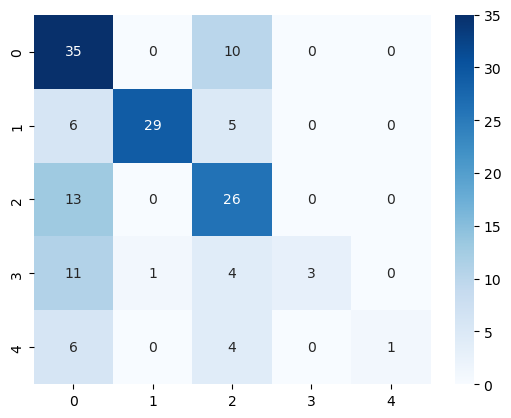

In [12]:
print(confusion_matrix(y_test,svm_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, svm_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 35 muestras de esta clase (verdaderos positivos), no predijo incorrectamente ninguna muestra de esta clase como otra clase (falsos negativos), y predijo incorrectamente 10 muestras de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 29 muestras de esta clase, no predijo incorrectamente ninguna muestra de esta clase como otra clase, y predijo incorrectamente 6 muestras de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 26 muestras de esta clase, no predijo incorrectamente ninguna muestra de esta clase como otra clase, y predijo incorrectamente 13 muestras de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 3 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otra clase, y predijo incorrectamente 11 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 1 muestra de esta clase, no predijo incorrectamente ninguna muestra de esta clase como otra clase, y predijo incorrectamente 10 muestras de otras clases como "PP".

En resumen, la matriz de confusión muestra la cantidad de instancias clasificadas correctamente e incorrectamente para cada clase. Es una herramienta útil para evaluar el rendimiento del modelo de clasificación y comprender dónde se producen los errores de clasificación.

In [13]:
# Save the model.
pickle.dump(model, open('../models/svc_model_tweets_pol.pkl', 'wb'))

**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

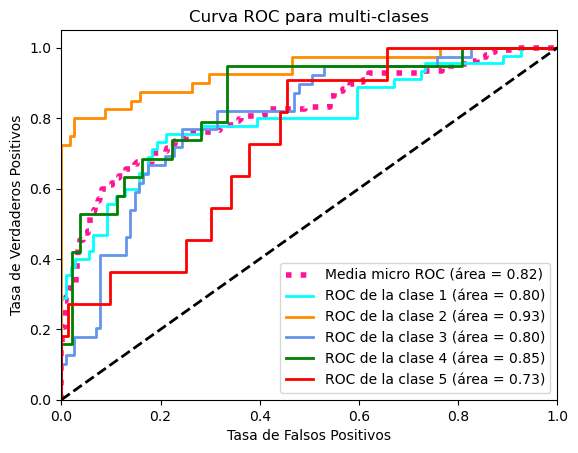

In [14]:
scores = svm_classifier.decision_function(X_test)
plot_roc_curves(y_test, scores, 'SVM')

                 Model  F2-score  F1-score  Accuracy
0                  SVM  0.593911  0.586744  0.610390
1          Naive Bayes  0.540811  0.521887  0.564935
2        XGBClassifier  0.605807  0.600585  0.610390
3         RandomForest  0.589755  0.578128  0.603896
4  Logistic Regression  0.606192  0.592018  0.623377


##  <a name="5"> Naive Bayes</a>

In [15]:
# Entrenar un modelo Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, nb_classifier)
nb_predictions = nb_classifier.predict(X_test)

**Imprimimos las métricas:**

In [16]:
print_classification_report(y_test, nb_predictions, 'Naive Bayes')

Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.44      0.80      0.57        45
           1       0.88      0.75      0.81        40
           2       0.54      0.51      0.53        39
           3       1.00      0.05      0.10        19
           4       0.00      0.00      0.00        11

    accuracy                           0.56       154
   macro avg       0.57      0.42      0.40       154
weighted avg       0.62      0.56      0.52       154

F2 Score: 0.54




**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[36  0  9  0  0]
 [ 6 30  4  0  0]
 [18  1 20  0  0]
 [14  1  3  1  0]
 [ 8  2  1  0  0]]


<Axes: >

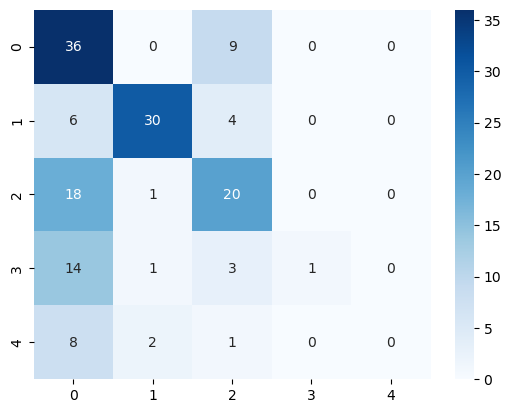

In [17]:
print(confusion_matrix(y_test,nb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, nb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 36 muestras de esta clase (verdaderos positivos), no predijo incorrectamente ninguna muestra de esta clase como otra clase (falsos negativos), y predijo incorrectamente 9 muestras de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 30 muestras de esta clase, no predijo incorrectamente ninguna muestra de esta clase como otra clase, y predijo incorrectamente 6 muestras de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 20 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otra clase, y predijo incorrectamente 18 muestras de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 1 muestra de esta clase, predijo incorrectamente 1 muestra de esta clase como otra clase, y predijo incorrectamente 14 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 0 muestras de esta clase, predijo incorrectamente 2 muestras de esta clase como otras clases, y predijo incorrectamente 9 muestras de otras clases como "PP".

La matriz de confusión nos proporciona información sobre la precisión y el rendimiento del modelo en la clasificación de cada clase. Nos ayuda a identificar los aciertos y errores de clasificación y a entender cómo el modelo está desempeñándose en cada clase específica.

In [18]:
# Save the model.
pickle.dump(model, open('../models/nb_model_tweets_pol.pkl', 'wb'))

**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

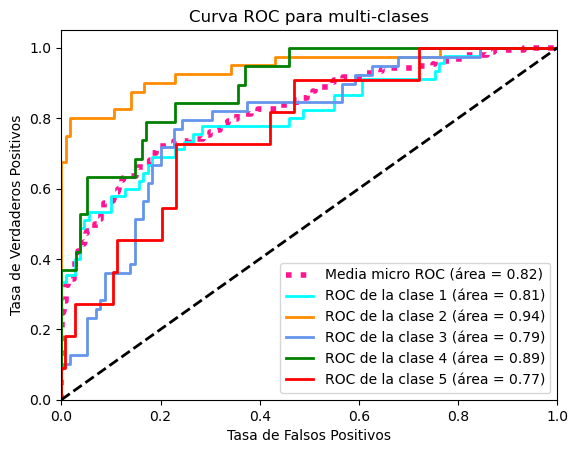

In [19]:
scores = nb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Naive Bayes')

##  <a name="6"> XGBoost Classifier</a>

In [20]:
# Entrenar un modelo XGBClassifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, xgb_classifier)
xgb_predictions = xgb_classifier.predict(X_test)

**Imprimimos las métricas:**

In [21]:
print_classification_report(y_test, xgb_predictions, 'XGBoost')

Model: XGBoost
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        45
           1       0.70      0.78      0.74        40
           2       0.55      0.56      0.56        39
           3       0.56      0.47      0.51        19
           4       0.40      0.18      0.25        11

    accuracy                           0.61       154
   macro avg       0.57      0.53      0.54       154
weighted avg       0.60      0.61      0.60       154

F2 Score: 0.61




**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[30  1  9  4  1]
 [ 4 31  4  0  1]
 [ 6  7 22  3  1]
 [ 3  3  4  9  0]
 [ 6  2  1  0  2]]


<Axes: >

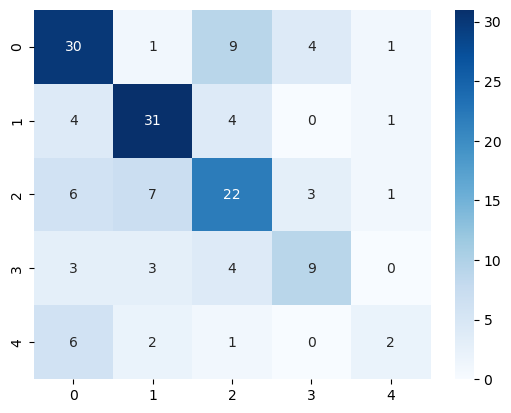

In [22]:
print(confusion_matrix(y_test,xgb_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, xgb_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 30 muestras de esta clase (verdaderos positivos), predijo incorrectamente 1 muestra de esta clase como otra clase (falsos negativos), y predijo incorrectamente 14 muestras de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 31 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otra clase, y predijo incorrectamente 9 muestras de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 22 muestras de esta clase, predijo incorrectamente 7 muestras de esta clase como otras clases, y predijo incorrectamente 10 muestras de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 9 muestras de esta clase, predijo incorrectamente 4 muestras de esta clase como otras clases, y predijo incorrectamente 7 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 2 muestras de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 10 muestras de otras clases como "PP".

La matriz de confusión nos proporciona información sobre la precisión y el rendimiento del modelo en la clasificación de cada clase. En este caso, podemos observar cómo el modelo se está desempeñando en la clasificación de cada clase y los tipos de errores que comete.

In [23]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_pol.pkl', 'wb'))

**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

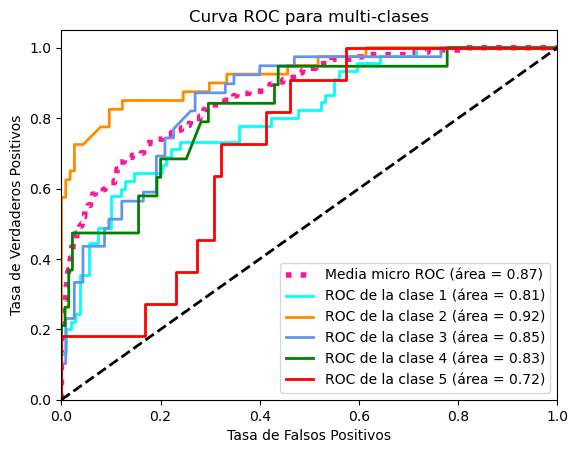

In [24]:
scores = xgb_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'XGBoost')

##  <a name="7"> Random Forest</a>

In [25]:
# Entrenar un modelo RandomForest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, rf_classifier)
rf_predictions = rf_classifier.predict(X_test)

**Imprimimos las métricas:**

In [26]:
print_classification_report(y_test, rf_predictions, 'Random Forest')

Model: Random Forest
              precision    recall  f1-score   support

           0       0.57      0.69      0.63        45
           1       0.64      0.85      0.73        40
           2       0.54      0.54      0.54        39
           3       0.86      0.32      0.46        19
           4       1.00      0.09      0.17        11

    accuracy                           0.60       154
   macro avg       0.72      0.50      0.50       154
weighted avg       0.65      0.60      0.58       154

F2 Score: 0.59




**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[31  3 11  0  0]
 [ 2 34  4  0  0]
 [ 8 10 21  0  0]
 [ 8  3  2  6  0]
 [ 5  3  1  1  1]]


<Axes: >

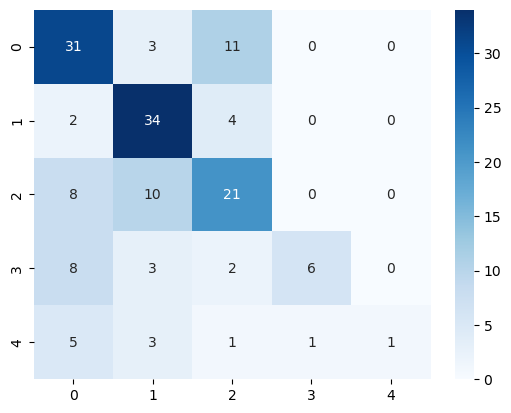

In [27]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 31 muestras de esta clase (verdaderos positivos), predijo incorrectamente 3 muestras de esta clase como otras clases (falsos negativos), y no predijo incorrectamente ninguna muestra de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 34 muestras de esta clase, predijo incorrectamente 4 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 21 muestras de esta clase, predijo incorrectamente 10 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 6 muestras de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 2 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 1 muestra de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 11 muestras de otras clases como "PP".

In [28]:
# Save the model.
pickle.dump(model, open('../models/rf_model_tweets_pol.pkl', 'wb'))

**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

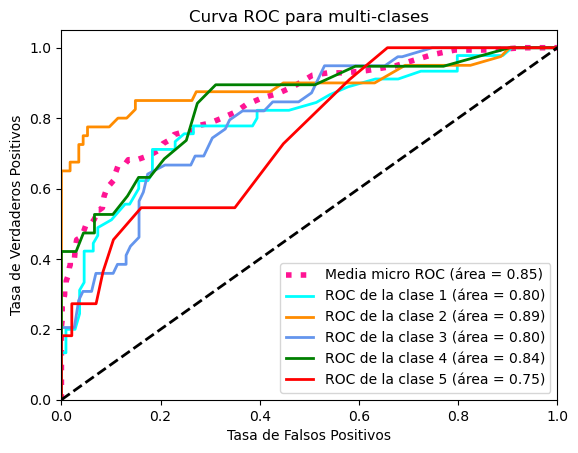

In [29]:
scores = rf_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Random Forest')

##  <a name="8"> Logistic Regression</a>

In [30]:
# Entrenar un modelo de Regresión Logística
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
model = make_pipeline(vectorizer, lr_classifier)
lr_predictions = lr_classifier.predict(X_test)

**Imprimimos las métricas:**

In [31]:
print_classification_report(y_test, lr_predictions, 'Logistic Regresion')

Model: Logistic Regresion
              precision    recall  f1-score   support

           0       0.52      0.76      0.61        45
           1       0.89      0.80      0.84        40
           2       0.54      0.67      0.60        39
           3       1.00      0.21      0.35        19
           4       0.00      0.00      0.00        11

    accuracy                           0.62       154
   macro avg       0.59      0.49      0.48       154
weighted avg       0.64      0.62      0.59       154

F2 Score: 0.61




**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[34  0 11  0  0]
 [ 4 32  4  0  0]
 [13  0 26  0  0]
 [ 9  1  5  4  0]
 [ 6  3  2  0  0]]


<Axes: >

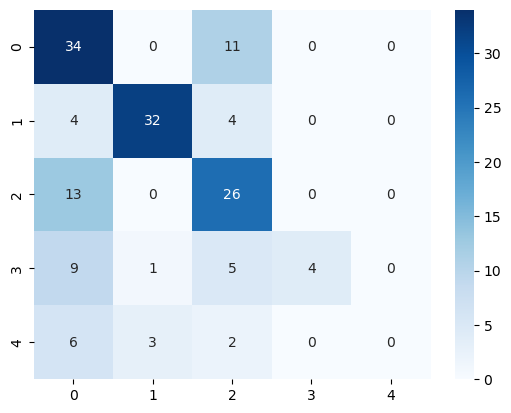

In [32]:
print(confusion_matrix(y_test,lr_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, lr_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 34 muestras de esta clase (verdaderos positivos), no predijo incorrectamente ninguna muestra de esta clase como otras clases (falsos negativos), y no predijo incorrectamente ninguna muestra de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 32 muestras de esta clase, predijo incorrectamente 4 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 26 muestras de esta clase, no predijo incorrectamente ninguna muestra de esta clase como otras clases, y predijo incorrectamente 13 muestras de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 4 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otras clases, y predijo incorrectamente 5 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 0 muestras de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 11 muestras de otras clases como "PP"..

In [33]:
# Save the model.

pickle.dump(model, open('../models/lr_model_tweets_pol.pkl', 'wb'))

**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

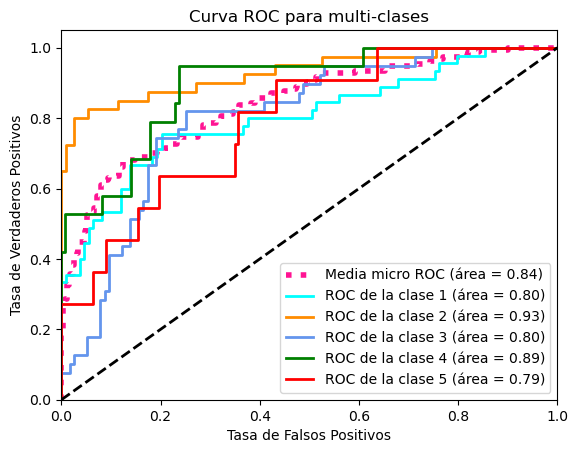

In [34]:
scores = lr_classifier.predict_proba(X_test)
plot_roc_curves(y_test, scores, 'Logistic Regression')

##  <a name="9"> Comparativo</a>

In [35]:
# Uso de la función con tus modelos y datos de prueba
models = [svm_classifier, nb_classifier, xgb_classifier, rf_classifier, lr_classifier]
model_names = ['SVM', 'Naive Bayes', 'XGBClassifier', 'RandomForest', 'Logistic Regression']
print_model_metrics(models, model_names, X_test, y_test)

                 Model  F2-score  F1-score  Accuracy
0                  SVM  0.593911  0.586744  0.610390
1          Naive Bayes  0.540811  0.521887  0.564935
2        XGBClassifier  0.605807  0.600585  0.610390
3         RandomForest  0.589755  0.578128  0.603896
4  Logistic Regression  0.606192  0.592018  0.623377


Tras comparar las metricas, pasamos a realizar un tunning de los parametros de los modelos:
 - XGBoost Classifier
 - Logistic Regression

##  <a name="10"> XGBoost Tunning</a>

In [36]:
# Define los parámetros que quieres ajustar
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Crea una nueva instancia del modelo
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Crea el objeto GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid=params, cv=5)

# Ajusta los datos
grid_search.fit(X_train, y_train)
model = make_pipeline(vectorizer, grid_search)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search.best_params_)

# Predice con los mejores parámetros
xgb_predictions = grid_search.predict(X_test)

Best Parameters:  {'colsample_bytree': 1.0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


**Imprimimos las métricas:**

In [37]:
print_classification_report(y_test, xgb_predictions, 'XGBoost')

Model: XGBoost
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        45
           1       0.74      0.80      0.77        40
           2       0.52      0.56      0.54        39
           3       0.56      0.47      0.51        19
           4       0.67      0.18      0.29        11

    accuracy                           0.62       154
   macro avg       0.62      0.54      0.55       154
weighted avg       0.62      0.62      0.61       154

F2 Score: 0.61




**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

           Model  F2-score  F1-score  Accuracy
0  XGBClassifier  0.611529  0.606259  0.616883


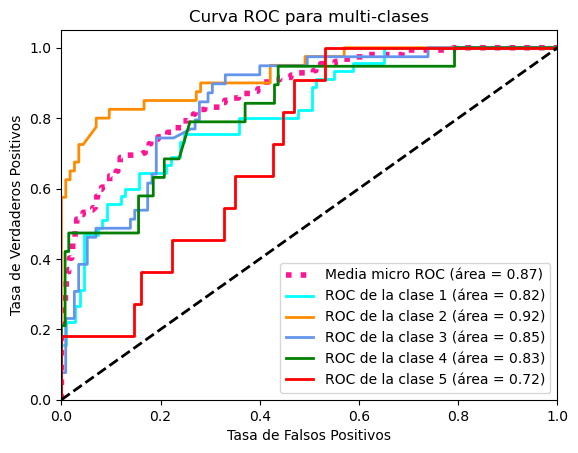

In [38]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search.best_estimator_]
model_names = ['XGBClassifier']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores = grid_search.predict_proba(X_test)

# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores, model_names)

In [39]:
# Save the model.
pickle.dump(model, open('../models/xgb_model_tweets_final_pol.pkl', 'wb'))

**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[31  3 11  0  0]
 [ 2 34  4  0  0]
 [ 8 10 21  0  0]
 [ 8  3  2  6  0]
 [ 5  3  1  1  1]]


<Axes: >

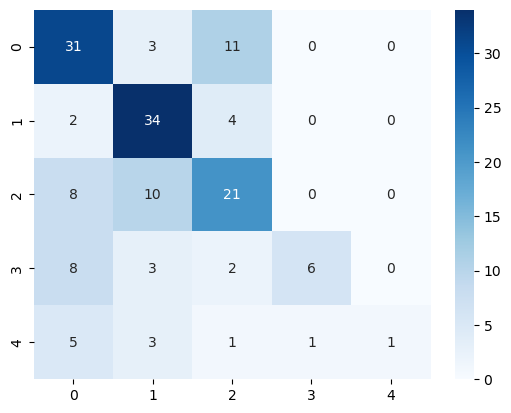

In [40]:
print(confusion_matrix(y_test,rf_predictions))
# Confusion matrix.
conf_mat = confusion_matrix(y_test, rf_predictions)
# Plot the heatmap.
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 31 muestras de esta clase (verdaderos positivos), predijo incorrectamente 3 muestras de esta clase como otras clases (falsos negativos), y no predijo incorrectamente ninguna muestra de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 34 muestras de esta clase, predijo incorrectamente 4 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 21 muestras de esta clase, predijo incorrectamente 10 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 6 muestras de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 2 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 1 muestra de esta clase, predijo incorrectamente 3 muestras de esta clase como otras clases, y predijo incorrectamente 10 muestras de otras clases como "PP".

##  <a name="11"> Logistic Regression Tunning</a>

In [41]:
# Define los parámetros que quieres ajustar
params_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Crea una nueva instancia del modelo
lr_classifier = LogisticRegression()

# Crea el objeto GridSearchCV
grid_search_lr = GridSearchCV(lr_classifier, param_grid=params_lr, cv=5)

# Ajusta los datos
grid_search_lr.fit(X_train, y_train)

# Imprime los mejores parámetros
print("Best Parameters: ", grid_search_lr.best_params_)

# Predice con los mejores parámetros
lr_predictions = grid_search_lr.predict(X_test)

Best Parameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}


**Imprimimos las métricas:**

In [42]:
print_classification_report(y_test, lr_predictions, 'Logistic Regression')

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.55      0.71      0.62        45
           1       0.91      0.75      0.82        40
           2       0.53      0.64      0.58        39
           3       0.77      0.53      0.62        19
           4       1.00      0.27      0.43        11

    accuracy                           0.65       154
   macro avg       0.75      0.58      0.62       154
weighted avg       0.70      0.65      0.65       154

F2 Score: 0.65




**Curva ROC (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

                 Model  F2-score  F1-score  Accuracy
0  Logistic Regression  0.646362   0.65001  0.649351


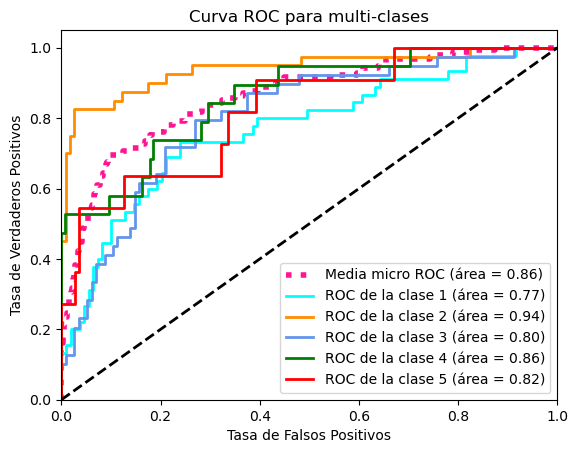

In [43]:
# Uso de la función con tus modelos y datos de prueba
models = [grid_search_lr.best_estimator_]
model_names = ['Logistic Regression']
print_model_metrics(models, model_names, X_test, y_test)

# Para usar la función plot_roc_curves, necesitas las puntuaciones de confianza de tu modelo
y_scores_lr = grid_search_lr.predict_proba(X_test)

# Ahora puedes llamar a tu función
plot_roc_curves(y_test, y_scores_lr, model_names)

In [44]:
# Guardar el modelo
pickle.dump(model, open('../models/lr_model_tweets_final_pol.pkl', 'wb'))

**Matriz de confusión (MÁS MADRID: 0, VOX: 1, PODEMOS: 2, PSOE: 3, PP: 4):**

[[32  0 12  1  0]
 [ 4 30  6  0  0]
 [13  1 25  0  0]
 [ 6  1  2 10  0]
 [ 3  1  2  2  3]]


<Axes: >

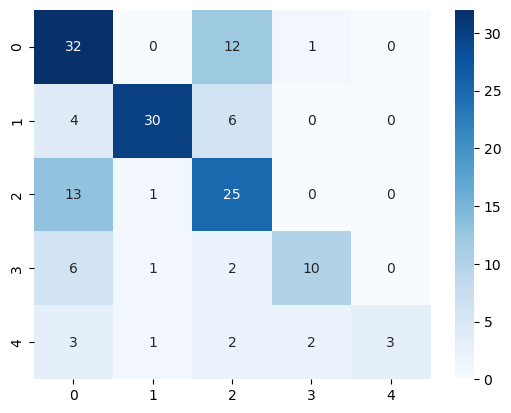

In [45]:
# Matriz de confusión
conf_mat = confusion_matrix(y_test, lr_predictions)
print(conf_mat)

# Plot de la matriz de confusión
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

En la primera fila, se observan los resultados de la clase "MÁS MADRID". El modelo predijo correctamente 32 muestras de esta clase (verdaderos positivos), no predijo incorrectamente ninguna muestra de esta clase como otras clases (falsos negativos), y predijo incorrectamente 12 muestras de otras clases como "MÁS MADRID" (falsos positivos).

En la segunda fila, se observan los resultados de la clase "VOX". El modelo predijo correctamente 30 muestras de esta clase, predijo incorrectamente 6 muestras de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "VOX".

En la tercera fila, se observan los resultados de la clase "PODEMOS". El modelo predijo correctamente 25 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otras clases, y no predijo incorrectamente ninguna muestra de otras clases como "PODEMOS".

En la cuarta fila, se observan los resultados de la clase "PSOE". El modelo predijo correctamente 10 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otras clases, y predijo incorrectamente 2 muestras de otras clases como "PSOE".

En la quinta fila, se observan los resultados de la clase "PP". El modelo predijo correctamente 3 muestras de esta clase, predijo incorrectamente 1 muestra de esta clase como otras clases, y predijo incorrectamente 7 muestras de otras clases como "PP".